In [3]:
!pip install contractions

You should consider upgrading via the 'c:\users\jorn\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
# importing 
import pandas as pd
import re
import numpy as np
import spacy
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import wordnet
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [2]:
# loading train data
train_data = pd.read_csv(r'D:\Purity\NLPbootcamp\Train_Data.csv')
print(train_data.shape)
train_data.head(10)

(44262, 2)


,headline,is_sarcastic
0,supreme court votes 7-2 to legalize all worldl...,1
1,hungover man horrified to learn he made dozens...,1
2,emily's list founder: women are the 'problem s...,0
3,send your kids back to school with confidence,0
4,watch: experts talk pesticides and health,0
5,james corden and the red hot chili peppers str...,0
6,u.s. dignity reserves nearly depleted,1
7,"how to re-ignite the spark in your body, mind ...",0
8,report: there still time to convert to christi...,1
9,education reform and evidence,0


In [3]:
# loading test data
test_data = pd.read_csv(r'D:\Purity\NLPbootcamp\Test_Data.csv')
print(test_data.shape)
test_data.head(10)

(11066, 1)


,headline
0,area stand-up comedian questions the deal with...
1,dozens of glowing exit signs mercilessly taunt...
2,perfect response to heckler somewhere in prop ...
3,gop prays for ossoff lossoff
4,trevor noah says the scary truth about trump's...
5,israeli pm debuts new road map for continued s...
6,"after careful thought, teen applies to college..."
7,historical archives: last month's weather
8,the importance of trying
9,michigan state took too long with sexual assau...


check missing values

In [4]:
train_data.isnull().sum()

headline        0
is_sarcastic    0
dtype: int64

In [5]:
test_data.isnull().sum()

headline    0
dtype: int64

Text preprocessing

In [6]:
# normalizing the documents
def normalize_document(doc):
    # remove special characters\whitespaces
    pattern = r'[^a-zA-Z0-9\s]'
    doc = re.sub(pattern, '', doc)
    doc = doc.strip()
    doc = contractions.fix(doc)
    return doc

In [7]:
# removing stopwords 
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
def remove_stop(doc):
    #tokenize words
    word_tokens = word_tokenize(doc)
    #removing stopwords
    filtered_tokens = [token for token in word_tokens if token not in stopwords]
    return filtered_tokens

In [8]:
# lematizing words
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
def lemmatize(doc):
    #POS tagging
    tagged_tokens = nltk.pos_tag(doc)
    # converting the tags
    wordnet_tokens = pos_tag_wordnet(tagged_tokens)
    #lemmatizing
    filtered_doc = ' '.join(wnl.lemmatize(word, tag) for word, tag in wordnet_tokens)
    return filtered_doc

In [9]:
# function for converting tags
def pos_tag_wordnet(tagged_tokens):
    tag_map = {'j': wordnet.ADJ, 'v': wordnet.VERB, 'n': wordnet.NOUN, 'r': wordnet.ADV}
    new_tagged_tokens = [(word, tag_map.get(tag[0].lower(), wordnet.NOUN))
                            for word, tag in tagged_tokens]
    return new_tagged_tokens

In [10]:
train_data['clean_data'] = train_data['headline'].apply(lambda x: normalize_document(x)) # normalize text
train_data['clean_data'] = train_data['clean_data'].apply(lambda x: remove_stop(x)) # remove stopwords
train_data['clean_data'] = train_data['clean_data'].apply(lambda x: lemmatize(x)) # lemmatize text
train_data.head()

,headline,is_sarcastic,clean_data
0,supreme court votes 7-2 to legalize all worldl...,1,supreme court vote 72 legalize worldly vice
1,hungover man horrified to learn he made dozens...,1,hungover man horrify learn dozen plan night
2,emily's list founder: women are the 'problem s...,0,emilys list founder woman problem solver congress
3,send your kids back to school with confidence,0,send kid school confidence
4,watch: experts talk pesticides and health,0,watch expert talk pesticide health


In [11]:
# checking imbalanced data
train_data['is_sarcastic'].value_counts()

0    23958
1    20304
Name: is_sarcastic, dtype: int64

splitting train data into train set and validation set

In [12]:
#importing train_test_split library
from sklearn.model_selection import train_test_split
#split to get test set
df_train, df_val = train_test_split(train_data, test_size=0.2, random_state=1)

In [13]:
#creating the label
y_train = df_train.is_sarcastic.values
y_val = df_val.is_sarcastic.values

In [14]:
print(df_train.shape), print(y_train.shape), print(df_val.shape), print(y_val.shape)

(35409, 3)
(35409,)
(8853, 3)
(8853,)


(None, None, None, None)

Encoding text data & feature engineering

In [15]:
# importing count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
#creating a function for encoding text data
def transform_text(data):
    #transforming with count vectorizer
    vectorizer = CountVectorizer()
    vectorizer.fit(df_train['clean_data'])
    cv = vectorizer.transform(data.clean_data)
    return cv

In [17]:
#transforming train data
train_data = transform_text(df_train)
print(train_data.shape)

(35409, 22282)


In [18]:
#transforming validation data
val_data = transform_text(df_val)
print(val_data.shape)

(8853, 22282)


Creating a model for training and testing

1. Logistic regression

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
lr = LogisticRegression(max_iter=500, solver='lbfgs')
lr.fit(train_data, y_train) #fitting  model

LogisticRegression(max_iter=500)

In [55]:
# examine model coefficients
print(lr.intercept_)
print(lr.coef_)

[-0.84950421]
[[ 0.55015896  0.00654082 -0.91718171 ...  1.49976162 -0.21771884
   0.58352041]]


In [56]:
#predicting 
y_pred = lr.predict(val_data)#predicting validation values
train_pred = lr.predict(train_data)#predicting train values
print(y_pred)

[1 1 1 ... 0 1 1]


In [57]:
# evaluation
print('train results')
print(classification_report(y_train,train_pred))
print(f'accuracy - {accuracy_score(y_train,train_pred)}')
print(' ')
print('Validation results')
print(classification_report(y_val,y_pred))
print(f'accuracy - {accuracy_score(y_val,y_pred)}')

train results
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     19205
           1       0.95      0.92      0.93     16204

    accuracy                           0.94     35409
   macro avg       0.94      0.94      0.94     35409
weighted avg       0.94      0.94      0.94     35409

accuracy - 0.9403823886582507
 
Validation results
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4753
           1       0.88      0.83      0.85      4100

    accuracy                           0.87      8853
   macro avg       0.87      0.86      0.86      8853
weighted avg       0.87      0.87      0.87      8853

accuracy - 0.8659211566700553


2. Decision Trees

In [50]:
from sklearn.tree import DecisionTreeClassifier
#training
dt = DecisionTreeClassifier(min_samples_leaf=1)
dt.fit(train_data, y_train)

DecisionTreeClassifier()

In [51]:
# predicting
y_pred = dt.predict(val_data)
train_pred = dt.predict(train_data)

In [52]:
# evaluation
print('train results')
print(classification_report(y_train,train_pred))
print(f'accuracy - {accuracy_score(y_train,train_pred)}')
print(' ')
print('Validation results')
print(classification_report(y_val,y_pred))
print(f'accuracy - {accuracy_score(y_val,y_pred)}')

train results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19205
           1       1.00      1.00      1.00     16204

    accuracy                           1.00     35409
   macro avg       1.00      1.00      1.00     35409
weighted avg       1.00      1.00      1.00     35409

accuracy - 1.0
 
Validation results
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4753
           1       0.90      0.88      0.89      4100

    accuracy                           0.90      8853
   macro avg       0.90      0.89      0.90      8853
weighted avg       0.90      0.90      0.90      8853

accuracy - 0.8961933807748785


In [82]:
#selecting the best max_depth and min sample of leaf
dt_scores = [] #creating an empty list
for d in [ 500, 600, 700, 800, 900, 1000, 1500, 2000]:#iterating max depth
    for s in [1, 5]:#iterating min leaf
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(train_data, y_train)
        y_pred = dt.predict(val_data)
        f1 = f1_score(y_val, y_pred)
        accuracy = accuracy_score(y_val,y_pred)
        dt_scores.append((d,s,f1,accuracy))

In [83]:
columns = ['max_depth', 'min_samples_leaf','F1_Score', 'Accuracy']
#creating dataframe
df_dtscores = pd.DataFrame(dt_scores, columns=columns)
df_dtscores

,max_depth,min_samples_leaf,F1_Score,Accuracy
0,500,1,0.804421,0.836101
1,500,5,0.716260,0.751836
2,600,1,0.824598,0.849543
3,600,5,0.723211,0.752287
4,700,1,0.837897,0.858918
5,700,5,0.728406,0.753869
6,800,1,0.836835,0.857901
7,800,5,0.727656,0.752174
8,900,1,0.844616,0.863888
9,900,5,0.729159,0.752287


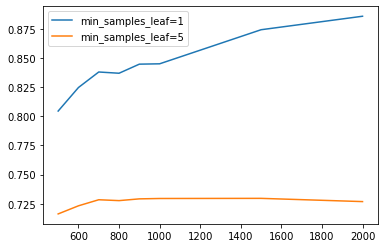

In [84]:
# plotting
for s in [1,5]:
    df_subset = df_dtscores[df_dtscores.min_samples_leaf == s]
    
    plt.plot(df_subset.max_depth, df_subset.F1_Score, 
             label='min_samples_leaf=%d' % s)

plt.legend()

3. Random Forest

In [47]:
# training
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50,
                            max_depth=1500,
                            random_state=1)
rf.fit(train_data, y_train)

RandomForestClassifier(max_depth=1500, n_estimators=50, random_state=1)

In [48]:
# predicting
y_pred = rf.predict(val_data)
train_pred = rf.predict(train_data)

In [49]:
# evaluation
print('train results')
print(classification_report(y_train,train_pred))
print(f'accuracy - {accuracy_score(y_train,train_pred)}')
print(' ')
print('Validation results')
print(classification_report(y_val,y_pred))
print(f'accuracy - {accuracy_score(y_val,y_pred)}')

train results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19205
           1       1.00      1.00      1.00     16204

    accuracy                           1.00     35409
   macro avg       1.00      1.00      1.00     35409
weighted avg       1.00      1.00      1.00     35409

accuracy - 0.9992657234036545
 
Validation results
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      4753
           1       0.94      0.85      0.89      4100

    accuracy                           0.91      8853
   macro avg       0.91      0.90      0.90      8853
weighted avg       0.91      0.91      0.90      8853

accuracy - 0.9050039534621033


In [23]:
#selecting the best max_depth and min sample of leaf
dt_scores = [] #creating an empty list
for d in [100,200,300,400, 500, 600, 700, 800]:#iterating max depth
    for n in [10, 20, 30, 40, 50]:#iterating min leaf
        rf = RandomForestClassifier(n_estimators=n,
                            max_depth=d,
                            random_state=1)
        rf.fit(train_data, y_train)
        y_pred = rf.predict(val_data)
        f1 = f1_score(y_val, y_pred)
        accuracy = accuracy_score(y_val,y_pred)
        dt_scores.append((d,n,f1,accuracy))

In [24]:
columns = ['max_depth', 'n_estimators','F1_Score', 'Accuracy']
#creating dataframe
df_dtscores = pd.DataFrame(dt_scores, columns=columns)
df_dtscores

,max_depth,n_estimators,F1_Score,Accuracy
0,100,10,0.686198,0.765277
1,100,20,0.706608,0.779849
2,100,30,0.709813,0.782221
3,100,40,0.712498,0.784593
4,100,50,0.708125,0.782108
5,200,10,0.761080,0.810008
6,200,20,0.768287,0.816446
7,200,30,0.773770,0.820739
8,200,40,0.777367,0.823111
9,200,50,0.776749,0.822998


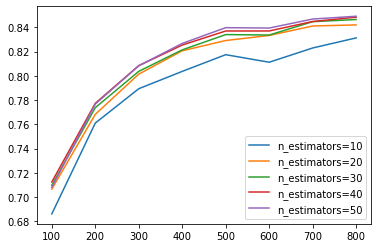

In [25]:
# plotting
for n in [10, 20, 30, 40, 50]:
    df_subset = df_dtscores[df_dtscores.n_estimators == n]
    
    plt.plot(df_subset.max_depth, df_subset.F1_Score, 
             label='n_estimators=%d' % n)

plt.legend()

Processing test data

In [71]:
test_data['clean_data'] = test_data['headline'].apply(lambda x: normalize_document(x)) # normalize text
test_data['clean_data'] = test_data['clean_data'].apply(lambda x: remove_stop(x)) # remove stopwords
test_data['clean_data'] = test_data['clean_data'].apply(lambda x: lemmatize(x)) # lemmatize text
test_data.head()

,headline,clean_data
0,area stand-up comedian questions the deal with...,area standup comedian question deal drivethru ...
1,dozens of glowing exit signs mercilessly taunt...,dozen glow exit sign mercilessly taunt multipl...
2,perfect response to heckler somewhere in prop ...,perfect response heckler prop comedian trunk
3,gop prays for ossoff lossoff,gop prays ossoff lossoff
4,trevor noah says the scary truth about trump's...,trevor noah say scary truth trump rumor love c...


Encoding test data

In [72]:
#transforming test data
test_df = transform_text(test_data)
print(test_df.shape)

(11066, 22282)


Predicting test data

In [73]:
# best model is random forest
preds = rf.predict(test_df)
preds

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [74]:
# creating dataframe of the scores
scores_df = pd.DataFrame(preds)
scores_df.columns = ['prediction']
scores_df.head()

,prediction
0,1
1,1
2,1
3,0
4,0


C:\Users\JORN\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prediction', ylabel='count'>

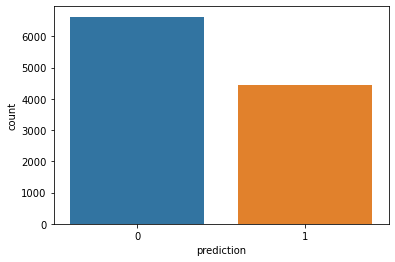

In [75]:
# Checking  the distribution of your predictions
import seaborn as sns
sns.countplot(scores_df.prediction)

In [77]:
#creating a csv file
scores_df.to_csv('results.csv', index = False)

In [76]:
scores_df.shape

(11066, 1)